In [1]:
import numpy as np
import copy
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, Sequential
from keras import regularizers
from keras import backend as K
import Data_prep as dp
from scipy.io import savemat, loadmat
from keras.losses import mse, binary_crossentropy
from keras.layers import Reshape, Lambda, Input, Dense, Flatten, Conv2D, Conv2DTranspose
from keras.layers import Activation, ZeroPadding2D, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
K.set_image_data_format('channels_last')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#DNN:

#regularization coefficient:
l=1.0

#act. func. (hidden layers)
act='tanh'

#act. func. (output layers)
act_out='linear'

#input/BC:
BC_input = Input(shape=(2, ), name = 'BC') #BC
bathy_input = Input(shape=(50,), name='bathymetry') #input
x = keras.layers.concatenate([bathy_input, BC_input])

#fully connected layer 1:
x = Dense(200, kernel_regularizer = regularizers.l2(l))(x)
x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)

#fully connected layer 2:
x = Dense(100, kernel_regularizer = regularizers.l2(l))(x)
x = BatchNormalization(axis = 1)(x)
x = Activation(act)(x)

#output:
outputs = Dense(50, activation=act_out, name='velocity')(x)

#set DNN model:
dnn = Model([bathy_input,BC_input], outputs, name='dnn')
dnn.summary()

Model: "dnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bathymetry (InputLayer)         (None, 50)           0                                            
__________________________________________________________________________________________________
BC (InputLayer)                 (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 52)           0           bathymetry[0][0]                 
                                                                 BC[0][0]                         
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          10600       concatenate_1[0][0]            

In [3]:
#DNN loss function (can use loss='mse' instead, but the function below allows defining custom loss function):

def dnn_loss(y_true, y_pred):
    dnn_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    return dnn_loss

In [4]:
#compile DNN:

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001, amsgrad=False)

dnn.compile(optimizer=opt, loss=dnn_loss)
dnn.summary()

Model: "dnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bathymetry (InputLayer)         (None, 50)           0                                            
__________________________________________________________________________________________________
BC (InputLayer)                 (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 52)           0           bathymetry[0][0]                 
                                                                 BC[0][0]                         
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          10600       concatenate_1[0][0]            

In [5]:
#load/read train and validation data

data = loadmat('Sav_BC_func_PCGA_1std_noise10_std4_zmax94_48_12_s0_5_6.mat')

vel0 = data['velocity_prof'] #velocities
z_f0 = data['z_f'] #free surface elevation
Q_b0 = data['Q_b'] #influx
Z0 = data['Z'] #bathymetry

#check data shape:
print(z_f0.shape)
print(Z0.shape)

(1, 4500)
(20541, 4500)


In [6]:
#load/read test data

data = loadmat('Sav_BC_func_PCGA_1std_noise10_std4_zmax94_48_12_s0_5_6_test.mat')

vel1 = data['velocity_prof'] #velocities
z_f1 = data['z_f'] #free surface elevation
Q_b1 = data['Q_b'] #influx
Z1 = data['Z'] #bathymetry

#check data shape:
print(z_f1.shape)
print(Z1.shape)

(1, 450)
(20541, 450)


In [7]:
#join train/validation and test set

vel = np.concatenate((vel0,vel1),axis=1)
z_f = np.concatenate((z_f0,z_f1),axis=1)
Q_b = np.concatenate((Q_b0,Q_b1),axis=1)
Z = np.concatenate((Z0,Z1),axis=1)
vx, vy, _ = dp.xy_vel_sep(vel) #v_x/v_y separation

#check data shape:
print(vel.shape)
print(z_f.shape)
print(vx.shape)
print(Z.shape)

(41082, 4950)
(1, 4950)
(20541, 4950)
(20541, 4950)


In [8]:
#normalize BC (ensure it's between 0 and 1):

BC = np.zeros((2, z_f.shape[1]))
BC[0,:] = z_f/120
BC[1,:] = Q_b/30000

#check shapes and maxes:
print(BC.shape)
print(max(BC[0,:]))
print(max(BC[1,:]))

(2, 4950)
0.9531882083041187
0.9988410701086574


In [9]:
# data preparation:

#generate a seed number for reproducibility:
seed_num=np.random.randint(0,1e5) 
#seed_num=0 #use for reproducing a previously known seed #
print(seed_num)

#generate seed:
np.random.seed(seed_num)

M=0 #where the first index of data is
P=450 #size of test set
H=10 #number of BCs for each profile

#shuffle based on the seed:
indx=np.array(np.arange(0+M,Z[:,0:].shape[1]-P,H),dtype=int) #original indices (ascending) 
indx_new=copy.deepcopy(indx) #new (to be shuffled) indices
np.random.shuffle(indx_new) #shuffled idices

#create shuffled input/outputs:
Z_shfl=copy.deepcopy(Z[:,0:])
vx_shfl=copy.deepcopy(vx[:,0:])
vy_shfl=copy.deepcopy(vy[:,0:])
BC_shfl=copy.deepcopy(BC[:,0:])
for i in range(indx_new.shape[0]):
    Z_shfl[:,i*H+M:i*H+H+M]=Z[:,indx_new[i]:indx_new[i]+H]
    vx_shfl[:,i*H+M:i*H+H+M]=vx[:,indx_new[i]:indx_new[i]+H]
    vy_shfl[:,i*H+M:i*H+H+M]=vx[:,indx_new[i]:indx_new[i]+H]
    BC_shfl[:,i*H+M:i*H+H+M]=BC[:,indx_new[i]:indx_new[i]+H]

17344


In [10]:
#PCA on input:

N=4500 # number of data to be used (train+validation)
val_split=0.1 #validation split (fraction of train/validation set to be used for validation)

U_Z,_,_ = np.linalg.svd(Z_shfl[:,:int(N-val_split*N)], full_matrices='False') #SVD

In [11]:
#PCA on output:

U_vx,_,_ = np.linalg.svd(vx_shfl[:,:int(N-val_split*N)], full_matrices='False') #SVD

In [12]:
#saving lowranks if necessary (check out the memoery, it is large!):

savemat('pca_Z',{'U_Z':U_Z})
savemat('pca_vx',{'U_vx':U_vx})

In [67]:
#loading lowranks if necessary :

data = loadmat('pca_Z.mat')
U_Z = data['U_Z']
data = loadmat('pca_vx.mat')
U_vx = data['U_vx']
del data

In [13]:
#input projection:

n_low_Z = 50 #low rank dim
proj_Z = U_Z[:,:n_low_Z].T.dot(Z_shfl)

x_train_shfl=proj_Z.T #input (Z)

#check shapes:
print(x_train_shfl.shape)

(4950, 50)


In [14]:
#output projection:

n_low_vx = 50 #low rank dim
proj_vx = U_vx[:,:n_low_vx].T.dot(vx_shfl)

y_train_shfl=proj_vx.T #output (vx; can be replaced with vy or both vx/vy)

#check shapes:
print(y_train_shfl.shape)

(4950, 50)


In [15]:
#find normalizing parameters:

x_min = np.mean(x_train_shfl[:int(N-val_split*N),:], axis=0)
y_min = np.mean(y_train_shfl[:int(N-val_split*N),:], axis=0)
x_range = np.std(x_train_shfl[:int(N-val_split*N),:], axis=0)
x_range[x_range==0]=1
y_range = np.std(y_train_shfl[:int(N-val_split*N),:], axis=0)
y_range[y_range==0]=1

#check shapes:
print(x_min.shape)
print(y_min.shape)
print(x_range.shape)
print(y_range.shape)

(50,)
(50,)
(50,)
(50,)


In [16]:
#normalize input/outputs:

x_train_norm_shfl = (x_train_shfl-x_min)/x_range 
y_train_norm_shfl = (y_train_shfl-y_min)/y_range 

#check shapes:
print(x_train_norm_shfl.shape)
print(y_train_norm_shfl.shape)

#check min/max:
print(np.min(x_train_norm_shfl[:int(N-val_split*N),:]))
print(np.min(y_train_norm_shfl[:int(N-val_split*N),:]))
print(np.max(x_train_norm_shfl[:int(N-val_split*N),:]))
print(np.max(y_train_norm_shfl[:int(N-val_split*N),:]))

(4950, 50)
(4950, 50)
-3.5451584806286736
-8.433328883335525
4.0108749869077425
10.611785039968181


In [17]:
#training:

#dnn.load_weights('pca_dnn_f_Sav_BC_func_m4500_B_200_100_50_l1_0tanlr0_001noB.h5') #to load saved weights, if necessary
dnn.fit(x={'bathymetry':x_train_norm_shfl[:-P,:], 'BC':BC_shfl[:,:-P].T},y=y_train_norm_shfl[:-P,:],
       epochs=400,batch_size=32,shuffle=False,validation_split=val_split)
dnn.save_weights('pca_dnn_f_Sav_BC_func_m4500_B_200_100_50_l1_0tanlr0_001noB.h5') #to save optimized weights

Train on 4050 samples, validate on 450 samples
Epoch 1/200
4050/4050 [==============================] - 1s 183us/step - loss: 74.5511 - val_loss: 12.2724
Epoch 2/200
4050/4050 [==============================] - 0s 45us/step - loss: 4.7433 - val_loss: 1.7991
Epoch 3/200
4050/4050 [==============================] - 0s 45us/step - loss: 1.5748 - val_loss: 1.3044
Epoch 4/200
4050/4050 [==============================] - 0s 46us/step - loss: 1.3232 - val_loss: 1.1719
Epoch 5/200
4050/4050 [==============================] - 0s 45us/step - loss: 1.2584 - val_loss: 1.1014
Epoch 6/200
4050/4050 [==============================] - 0s 45us/step - loss: 1.1745 - val_loss: 1.0609
Epoch 7/200
4050/4050 [==============================] - ETA: 0s - loss: 1.120 - 0s 50us/step - loss: 1.1307 - val_loss: 1.0059
Epoch 8/200
4050/4050 [==============================] - 0s 61us/step - loss: 1.0923 - val_loss: 0.9763
Epoch 9/200
4050/4050 [==============================] - 0s 50us/step - loss: 1.0519 - val_los

4050/4050 [==============================] - 0s 40us/step - loss: 0.7168 - val_loss: 0.6435
Epoch 79/200
4050/4050 [==============================] - 0s 40us/step - loss: 0.7157 - val_loss: 0.6426
Epoch 80/200
4050/4050 [==============================] - 0s 40us/step - loss: 0.7144 - val_loss: 0.6411
Epoch 81/200
4050/4050 [==============================] - 0s 41us/step - loss: 0.7134 - val_loss: 0.6407
Epoch 82/200
4050/4050 [==============================] - 0s 41us/step - loss: 0.7122 - val_loss: 0.6402
Epoch 83/200
4050/4050 [==============================] - 0s 41us/step - loss: 0.7112 - val_loss: 0.6391
Epoch 84/200
4050/4050 [==============================] - 0s 44us/step - loss: 0.7101 - val_loss: 0.6387
Epoch 85/200
4050/4050 [==============================] - 0s 62us/step - loss: 0.7091 - val_loss: 0.6374
Epoch 86/200
4050/4050 [==============================] - 0s 54us/step - loss: 0.7080 - val_loss: 0.6368
Epoch 87/200
4050/4050 [==============================] - 0s 47us/st

4050/4050 [==============================] - 0s 40us/step - loss: 0.6621 - val_loss: 0.6126
Epoch 156/200
4050/4050 [==============================] - 0s 41us/step - loss: 0.6616 - val_loss: 0.6135
Epoch 157/200
4050/4050 [==============================] - 0s 39us/step - loss: 0.6612 - val_loss: 0.6118
Epoch 158/200
4050/4050 [==============================] - 0s 40us/step - loss: 0.6607 - val_loss: 0.6138
Epoch 159/200
4050/4050 [==============================] - 0s 41us/step - loss: 0.6603 - val_loss: 0.6122
Epoch 160/200
4050/4050 [==============================] - 0s 39us/step - loss: 0.6599 - val_loss: 0.6142
Epoch 161/200
4050/4050 [==============================] - 0s 41us/step - loss: 0.6594 - val_loss: 0.6123
Epoch 162/200
4050/4050 [==============================] - 0s 40us/step - loss: 0.6590 - val_loss: 0.6127
Epoch 163/200
4050/4050 [==============================] - 0s 40us/step - loss: 0.6585 - val_loss: 0.6137
Epoch 164/200
4050/4050 [==============================] - 0

In [24]:
#calculate DNN predictions (normalized):

y_dnn_pred = dnn.predict([x_train_norm_shfl,BC_shfl.T]) #dnn output

#check shape:
print(y_dnn_pred.shape)

(4950, 50)


In [25]:
#calculate DNN predictions:

y_pred=y_dnn_pred*y_range+y_min #predicted output

y_pred_pca = U_vx[:, :n_low_vx].dot(y_pred.T) #project back

#check shape:
print(y_pred_pca.shape)

(20541, 4950)


In [35]:
#rmse of train/test/validation:

print('train err [ft/s]:',np.sqrt(np.mean((y_pred_pca[:,:int(N-val_split*N)]-vx_shfl[:,:int(N-val_split*N)])**2)))
print('test err [ft/s]:',np.sqrt(np.mean((y_pred_pca[:,int(N-val_split*N):N]-vx_shfl[:,int(N-val_split*N):N])**2)))
print('validation err [ft/s]:',np.sqrt(np.mean((y_pred_pca[:,N:]-vx_shfl[:,N:])**2)))

train err [ft/s]: 0.1968724042967052
test err [ft/s]: 0.19802780156711872
validation err [ft/s]: 0.21627368172152206


In [27]:
#prepare the data for plotting

x_plt=np.zeros((N+P,41, 501))
x_plt[:,:40,:500]=y_pred_pca.T.reshape(-1,41,501)[:,:40,:500].squeeze()
x_plt[:, 40,:]=x_plt[:, 39,:]
x_plt[:, :,500]=x_plt[:, :,499]
y_plt=np.zeros((N+P,41, 501))
y_plt[:,:40,:500]=vx_shfl.T.reshape(-1,41,501)[:,:40,:500].squeeze()
y_plt[:, 40,:]=y_plt[:, 39,:]
y_plt[:, :,500]=y_plt[:, :,499]

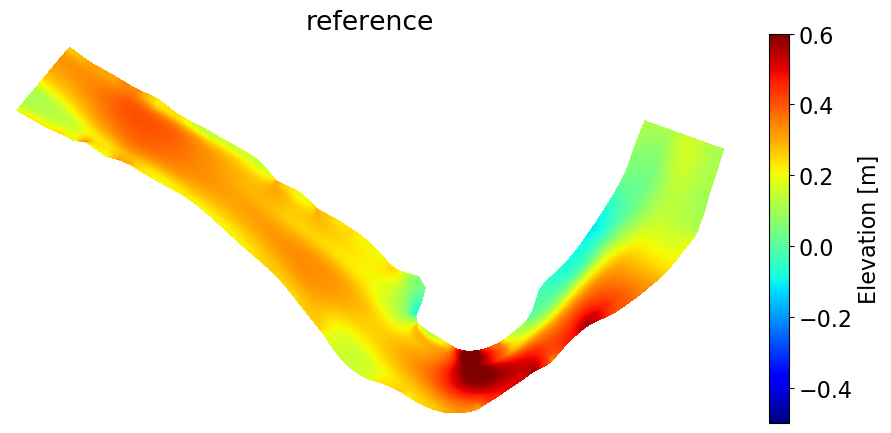

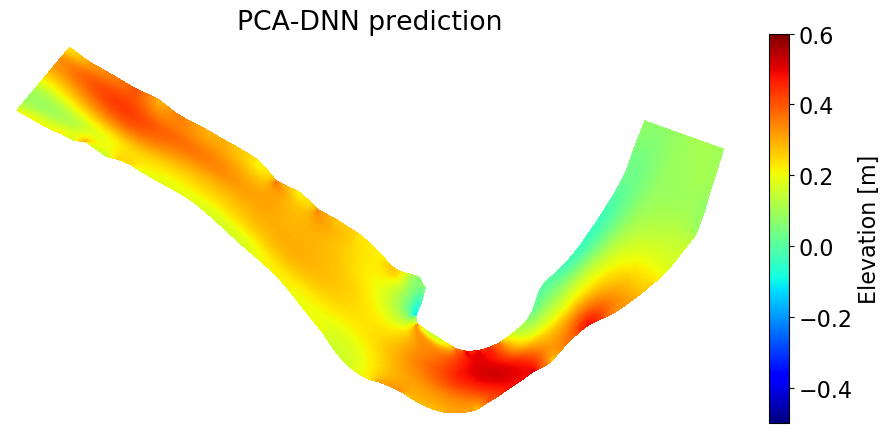

In [37]:
#plot some results:

#index (k<int(N-val_split*N) is a train data, int(N-val_split*N)<k<N is a test data, k>N is a validation data)
k=4700

dp.plt_im_tri(depth=y_plt[k, :,:].ravel(), fig_title= 'reference', fig_name='ref_global.png',vmin_=-0.5, vmax_=0.6)
dp.plt_im_tri(depth=(x_plt[k, :,:]).ravel(), fig_title= 'PCA-DNN prediction', fig_name='pca_dnn_global.png',vmin_=-0.5, vmax_=0.6)